<a href="https://colab.research.google.com/github/derrickrajkumar10-tech/FUTURE_ML_01/blob/main/notebooks/Tuning_Prophet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from itertools import product
import warnings
warnings.filterwarnings("ignore")



In [2]:
from google.colab import files
uploaded = files.upload()

Saving Sample - Superstore.csv to Sample - Superstore.csv


In [3]:
df = pd.read_csv("Sample - Superstore.csv", encoding="latin1")
print("="*60)
print("📊 DATASET OVERVIEW")
print("="*60)
print(f"\nDataset shape: {df.shape}")
print(f"\nColumns: {df.columns.tolist()}")
print(f"\nFirst 5 rows:")
print(df.head())

print(f"\n\nData types:")
print(df.dtypes)

print(f"\n\nMissing values:")
print(df.isnull().sum())

print(f"\n\nBasic statistics:")
print(df[['Sales', 'Quantity', 'Profit', 'Discount']].describe())


📊 DATASET OVERVIEW

Dataset shape: (9994, 21)

Columns: ['Row ID', 'Order ID', 'Order Date', 'Ship Date', 'Ship Mode', 'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State', 'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category', 'Product Name', 'Sales', 'Quantity', 'Discount', 'Profit']

First 5 rows:
   Row ID        Order ID  Order Date   Ship Date       Ship Mode Customer ID  \
0       1  CA-2016-152156   11/8/2016  11/11/2016    Second Class    CG-12520   
1       2  CA-2016-152156   11/8/2016  11/11/2016    Second Class    CG-12520   
2       3  CA-2016-138688   6/12/2016   6/16/2016    Second Class    DV-13045   
3       4  US-2015-108966  10/11/2015  10/18/2015  Standard Class    SO-20335   
4       5  US-2015-108966  10/11/2015  10/18/2015  Standard Class    SO-20335   

     Customer Name    Segment        Country             City  ...  \
0      Claire Gute   Consumer  United States        Henderson  ...   
1      Claire Gute   Consumer  United Stat

Date range: 2014-01-03 00:00:00 to 2017-12-30 00:00:00
Total days: 1457 days

Daily sales data shape: (1237, 2)
Average daily sales: $1,857.07
Max daily sales: $28,106.72
Min daily sales: $2.02


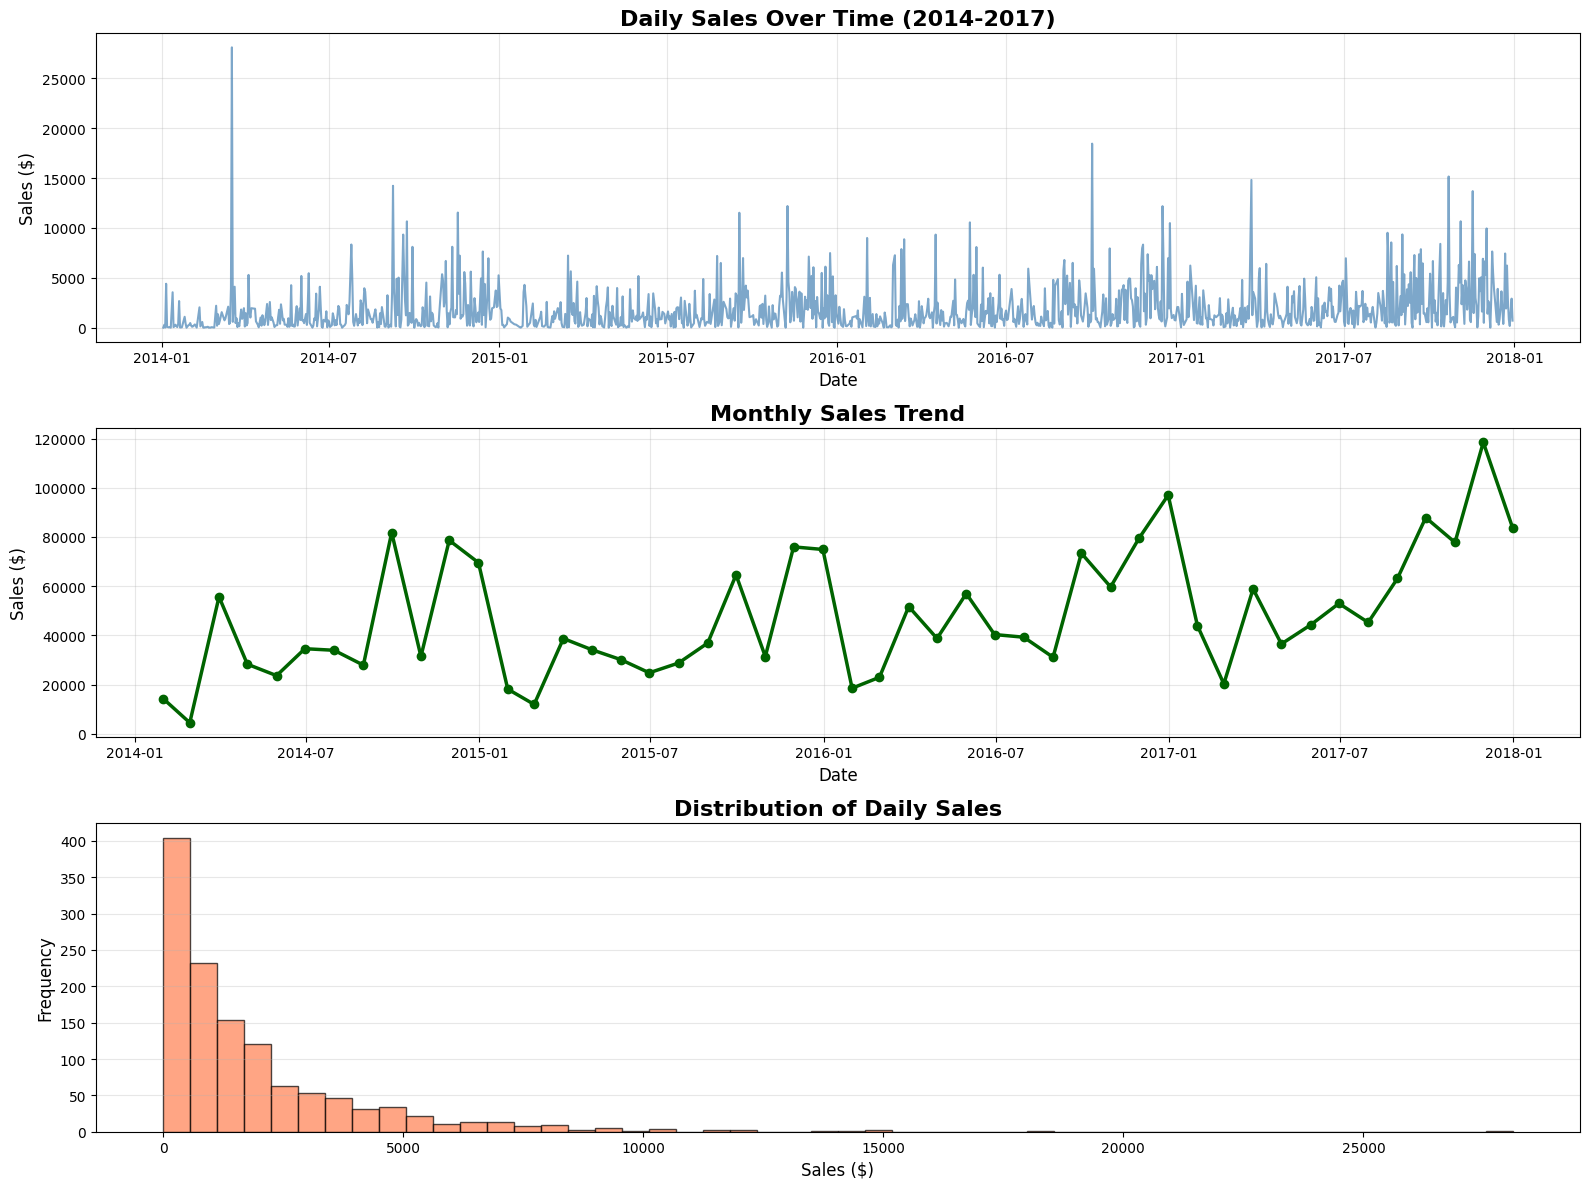

Yearly Sales Summary:
      Total Sales  Avg Daily Sales  Number of Days
Year                                              
2014  484247.4981       242.974159            1993
2015  470532.5090       223.849909            2102
2016  609205.5980       235.487282            2587
2017  733215.2552       221.381418            3312


In [4]:
# Convert date column to datetime
df['Order Date'] = pd.to_datetime(df['Order Date'])

# Check date range
print(f"Date range: {df['Order Date'].min()} to {df['Order Date'].max()}")
print(f"Total days: {(df['Order Date'].max() - df['Order Date'].min()).days} days")

# Aggregate to daily sales
daily_sales = df.groupby('Order Date')['Sales'].sum().reset_index()
daily_sales.columns = ['Date', 'Sales']

print(f"\nDaily sales data shape: {daily_sales.shape}")
print(f"Average daily sales: ${daily_sales['Sales'].mean():,.2f}")
print(f"Max daily sales: ${daily_sales['Sales'].max():,.2f}")
print(f"Min daily sales: ${daily_sales['Sales'].min():,.2f}")

# Visualization 1: Daily Sales Over Time
fig, axes = plt.subplots(3, 1, figsize=(16, 12))

# Plot 1: Full time series
axes[0].plot(daily_sales['Date'], daily_sales['Sales'], color='steelblue', linewidth=1.5, alpha=0.7)
axes[0].set_title('Daily Sales Over Time (2014-2017)', fontsize=16, fontweight='bold')
axes[0].set_xlabel('Date', fontsize=12)
axes[0].set_ylabel('Sales ($)', fontsize=12)
axes[0].grid(True, alpha=0.3)

# Plot 2: Monthly aggregation
monthly_sales = df.groupby(pd.Grouper(key='Order Date', freq='M'))['Sales'].sum().reset_index()
axes[1].plot(monthly_sales['Order Date'], monthly_sales['Sales'],
             color='darkgreen', linewidth=2.5, marker='o', markersize=6)
axes[1].set_title('Monthly Sales Trend', fontsize=16, fontweight='bold')
axes[1].set_xlabel('Date', fontsize=12)
axes[1].set_ylabel('Sales ($)', fontsize=12)
axes[1].grid(True, alpha=0.3)

# Plot 3: Sales distribution
axes[2].hist(daily_sales['Sales'], bins=50, color='coral', edgecolor='black', alpha=0.7)
axes[2].set_title('Distribution of Daily Sales', fontsize=16, fontweight='bold')
axes[2].set_xlabel('Sales ($)', fontsize=12)
axes[2].set_ylabel('Frequency', fontsize=12)
axes[2].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Yearly sales summary
df['Year'] = df['Order Date'].dt.year
yearly_summary = df.groupby('Year')['Sales'].agg(['sum', 'mean', 'count'])
yearly_summary.columns = ['Total Sales', 'Avg Daily Sales', 'Number of Days']
print("Yearly Sales Summary:")
print(yearly_summary)

✅ Feature engineering completed!

Total features created: 25

Feature list:
  1. Order Date
  2. Sales
  3. Quantity
  4. Profit
  5. Discount
  6. Year
  7. Month
  8. Quarter
  9. Day_of_Week
  10. Week_of_Year
  11. Day_of_Month
  12. Is_Weekend
  13. Is_Month_Start
  14. Is_Month_End
  15. Is_Q4
  16. Is_Holiday_Season
  17. Is_Summer
  18. Sales_7day_avg
  19. Sales_30day_avg
  20. Sales_7day_std
  21. Sales_lag_1
  22. Sales_lag_7
  23. Sales_lag_30
  24. Sales_growth_7d
  25. Sales_growth_30d


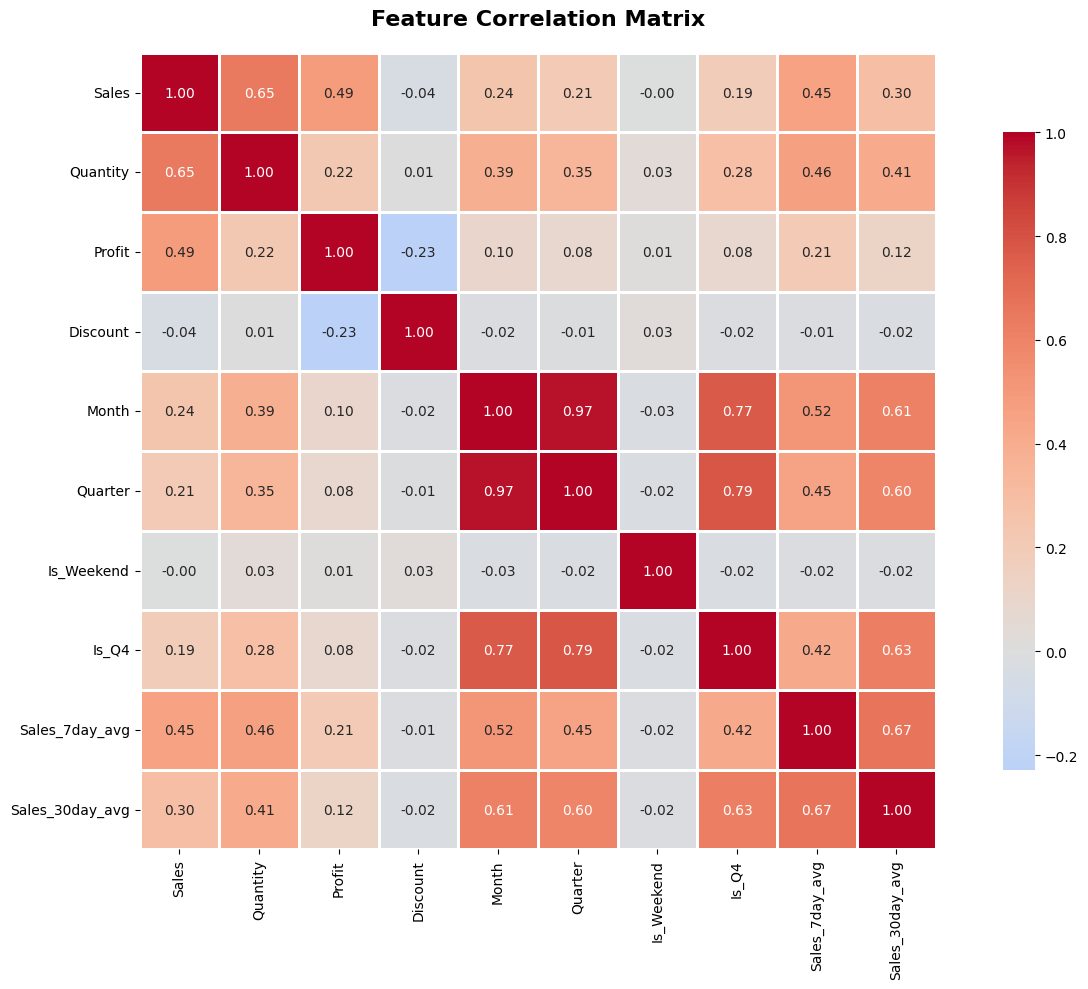

In [5]:
# Create comprehensive feature set
daily_data = df.groupby('Order Date').agg({
    'Sales': 'sum',
    'Quantity': 'sum',
    'Profit': 'sum',
    'Discount': 'mean'
}).reset_index()

# Time-based features
daily_data['Year'] = daily_data['Order Date'].dt.year
daily_data['Month'] = daily_data['Order Date'].dt.month
daily_data['Quarter'] = daily_data['Order Date'].dt.quarter
daily_data['Day_of_Week'] = daily_data['Order Date'].dt.dayofweek
daily_data['Week_of_Year'] = daily_data['Order Date'].dt.isocalendar().week
daily_data['Day_of_Month'] = daily_data['Order Date'].dt.day
daily_data['Is_Weekend'] = daily_data['Day_of_Week'].isin([5, 6]).astype(int)
daily_data['Is_Month_Start'] = (daily_data['Day_of_Month'] <= 5).astype(int)
daily_data['Is_Month_End'] = (daily_data['Day_of_Month'] >= 25).astype(int)

# Seasonal indicators
daily_data['Is_Q4'] = (daily_data['Quarter'] == 4).astype(int)
daily_data['Is_Holiday_Season'] = daily_data['Month'].isin([11, 12]).astype(int)
daily_data['Is_Summer'] = daily_data['Month'].isin([6, 7, 8]).astype(int)

# Rolling statistics
daily_data['Sales_7day_avg'] = daily_data['Sales'].rolling(window=7, min_periods=1).mean()
daily_data['Sales_30day_avg'] = daily_data['Sales'].rolling(window=30, min_periods=1).mean()
daily_data['Sales_7day_std'] = daily_data['Sales'].rolling(window=7, min_periods=1).std()

# Lag features
daily_data['Sales_lag_1'] = daily_data['Sales'].shift(1)
daily_data['Sales_lag_7'] = daily_data['Sales'].shift(7)
daily_data['Sales_lag_30'] = daily_data['Sales'].shift(30)

# Growth rates
daily_data['Sales_growth_7d'] = ((daily_data['Sales'] - daily_data['Sales_lag_7']) /
                                  daily_data['Sales_lag_7'] * 100)
daily_data['Sales_growth_30d'] = ((daily_data['Sales'] - daily_data['Sales_lag_30']) /
                                   daily_data['Sales_lag_30'] * 100)

print("✅ Feature engineering completed!")
print(f"\nTotal features created: {daily_data.shape[1]}")
print(f"\nFeature list:")
for i, col in enumerate(daily_data.columns, 1):
    print(f"  {i}. {col}")

# Visualize feature correlations
plt.figure(figsize=(14, 10))
corr_cols = ['Sales', 'Quantity', 'Profit', 'Discount', 'Month', 'Quarter',
             'Is_Weekend', 'Is_Q4', 'Sales_7day_avg', 'Sales_30day_avg']
corr_matrix = daily_data[corr_cols].corr()
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Feature Correlation Matrix', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

In [8]:

# Black Friday dates (4th Friday of November)
black_friday = pd.DataFrame({
    'holiday': 'black_friday',
    'ds': pd.to_datetime([
        '2014-11-28', '2015-11-27', '2016-11-25', '2017-11-24'
    ]),
    'lower_window': -2,   # Thanksgiving week starts early
    'upper_window': 4,    # Extends through Cyber Monday
})

# Cyber Monday (Monday after Black Friday)
cyber_monday = pd.DataFrame({
    'holiday': 'cyber_monday',
    'ds': pd.to_datetime([
        '2014-12-01', '2015-11-30', '2016-11-28', '2017-11-27'
    ]),
    'lower_window': 0,
    'upper_window': 1,
})

# Christmas season
christmas = pd.DataFrame({
    'holiday': 'christmas',
    'ds': pd.to_datetime([
        '2014-12-24', '2014-12-25', '2014-12-26',
        '2015-12-24', '2015-12-25', '2015-12-26',
        '2016-12-24', '2016-12-25', '2016-12-26',
        '2017-12-24', '2017-12-25', '2017-12-26',
    ]),
    'lower_window': -3,   # Pre-Christmas shopping rush
    'upper_window': 2,    # After-Christmas sales
})

# New Year
new_year = pd.DataFrame({
    'holiday': 'new_year',
    'ds': pd.to_datetime([
        '2014-12-31', '2015-01-01',
        '2015-12-31', '2016-01-01',
        '2016-12-31', '2017-01-01',
        '2017-12-31', '2018-01-01',
    ]),
    'lower_window': -1,
    'upper_window': 2,
})

# Thanksgiving
thanksgiving = pd.DataFrame({
    'holiday': 'thanksgiving',
    'ds': pd.to_datetime([
        '2014-11-27', '2015-11-26', '2016-11-24', '2017-11-23'
    ]),
    'lower_window': -1,
    'upper_window': 1,
})

# Independence Day
independence_day = pd.DataFrame({
    'holiday': 'independence_day',
    'ds': pd.to_datetime([
        '2014-07-04', '2015-07-04', '2016-07-04', '2017-07-04'
    ]),
    'lower_window': -1,
    'upper_window': 1,
})

# Labor Day (1st Monday of September)
labor_day = pd.DataFrame({
    'holiday': 'labor_day',
    'ds': pd.to_datetime([
        '2014-09-01', '2015-09-07', '2016-09-05', '2017-09-04'
    ]),
    'lower_window': -1,
    'upper_window': 1,
})

# Memorial Day (last Monday of May)
memorial_day = pd.DataFrame({
    'holiday': 'memorial_day',
    'ds': pd.to_datetime([
        '2014-05-26', '2015-05-25', '2016-05-30', '2017-05-29'
    ]),
    'lower_window': -1,
    'upper_window': 1,
})

# Combine all holidays
all_holidays = pd.concat([
    black_friday, cyber_monday, christmas, new_year,
    thanksgiving, independence_day, labor_day, memorial_day
], ignore_index=True)


print(f"\nTotal holiday events: {len(all_holidays)}")

print(all_holidays['holiday'].value_counts())
print(f"\nSample holidays:")
print(all_holidays.head(10))


Total holiday events: 44
holiday
christmas           12
new_year             8
cyber_monday         4
black_friday         4
thanksgiving         4
independence_day     4
labor_day            4
memorial_day         4
Name: count, dtype: int64

Sample holidays:
        holiday         ds  lower_window  upper_window
0  black_friday 2014-11-28            -2             4
1  black_friday 2015-11-27            -2             4
2  black_friday 2016-11-25            -2             4
3  black_friday 2017-11-24            -2             4
4  cyber_monday 2014-12-01             0             1
5  cyber_monday 2015-11-30             0             1
6  cyber_monday 2016-11-28             0             1
7  cyber_monday 2017-11-27             0             1
8     christmas 2014-12-24            -3             2
9     christmas 2014-12-25            -3             2


In [13]:
# Prepare Prophet dataset (requires 'ds' and 'y' columns)
df_prophet = daily_sales.copy()
df_prophet.columns = ['ds', 'y']

# Remove any rows with missing values
df_prophet = df_prophet.dropna()

# Sort by date
df_prophet = df_prophet.sort_values('ds').reset_index(drop=True)

print(f"\nShape: {df_prophet.shape}")
print(f"Date range: {df_prophet['ds'].min()} to {df_prophet['ds'].max()}")
print(f"Total days: {len(df_prophet)}")
print(f"\nSample data:")
print(df_prophet.head())
print("\n...")
print(df_prophet.tail())

# Train-test split (80-20)
split_point = int(len(df_prophet) * 0.80)
train = df_prophet[:split_point].copy()
test = df_prophet[split_point:].copy()

print(f"Training set: {len(train)} days ({train['ds'].min().date()} to {train['ds'].max().date()})")
print(f"Test set: {len(test)} days ({test['ds'].min().date()} to {test['ds'].max().date()})")
print(f"\nTraining period: {(train['ds'].max() - train['ds'].min()).days} days")
print(f"Test period: {(test['ds'].max() - test['ds'].min()).days} days")


Shape: (1237, 2)
Date range: 2014-01-03 00:00:00 to 2017-12-30 00:00:00
Total days: 1237

Sample data:
          ds         y
0 2014-01-03    16.448
1 2014-01-04   288.060
2 2014-01-05    19.536
3 2014-01-06  4407.100
4 2014-01-07    87.158

...
             ds          y
1232 2017-12-26   814.5940
1233 2017-12-27   177.6360
1234 2017-12-28  1657.3508
1235 2017-12-29  2915.5340
1236 2017-12-30   713.7900
Training set: 989 days (2014-01-03 to 2017-04-03)
Test set: 248 days (2017-04-04 to 2017-12-30)

Training period: 1186 days
Test period: 270 days


In [15]:


# Simple baseline model
model_baseline = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False,
)

model_baseline.fit(train)
print("Baseline model trained!")

# Make predictions
future_baseline = model_baseline.make_future_dataframe(periods=len(test))
forecast_baseline = model_baseline.predict(future_baseline)

# Evaluate on test set
test_forecast_baseline = forecast_baseline[forecast_baseline['ds'].isin(test['ds'])][['ds', 'yhat']]
test_forecast_baseline = test_forecast_baseline.merge(test, on='ds')

# Calculate metrics
mae_baseline = mean_absolute_error(test_forecast_baseline['y'], test_forecast_baseline['yhat'])
rmse_baseline = np.sqrt(mean_squared_error(test_forecast_baseline['y'], test_forecast_baseline['yhat']))
mape_baseline = np.mean(np.abs((test_forecast_baseline['y'] - test_forecast_baseline['yhat']) /
                                test_forecast_baseline['y'])) * 100
r2_baseline = r2_score(test_forecast_baseline['y'], test_forecast_baseline['yhat'])
accuracy_baseline = 100 - mape_baseline

print(f"BASELINE MODEL PERFORMANCE:")
print(f"  MAE:      ${mae_baseline:,.2f}")
print(f"  RMSE:     ${rmse_baseline:,.2f}")
print(f"  MAPE:     {mape_baseline:.2f}%")
print(f"  Accuracy: {accuracy_baseline:.2f}%")
print(f"  R² Score: {r2_baseline:.4f}")

Baseline model trained!
BASELINE MODEL PERFORMANCE:
  MAE:      $1,685.73
  RMSE:     $2,368.42
  MAPE:     564.99%
  Accuracy: -464.99%
  R² Score: 0.0946


In [16]:

# Create enhanced Prophet model with optimal parameters
model_enhanced = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False,
    holidays=all_holidays,
    seasonality_mode='multiplicative',    # Better for retail (percentage changes)
    changepoint_prior_scale=0.08,         # Slightly more flexible than 0.05
    seasonality_prior_scale=15,           # Strong seasonality (retail has big swings)
    holidays_prior_scale=20,              # Holidays have major impact on retail
    changepoint_range=0.9,                # Allow trend changes through 90% of data
    n_changepoints=30,                    # More changepoints for better trend capture
    interval_width=0.95,                  # 95% confidence intervals
)

# Add custom monthly seasonality
model_enhanced.add_seasonality(
    name='monthly',
    period=30.5,
    fourier_order=6,    # Increased from 5 for better monthly patterns
)

# Add quarterly seasonality (Q4 is huge for retail!)
model_enhanced.add_seasonality(
    name='quarterly',
    period=91.25,
    fourier_order=10,   # Increased from 8 for complex quarterly patterns
)

# Add semi-annual seasonality (mid-year vs end-year)
model_enhanced.add_seasonality(
    name='semi_annual',
    period=182.5,
    fourier_order=5,
)

print("Training model... ")
model_enhanced.fit(train)


# Make predictions
future_enhanced = model_enhanced.make_future_dataframe(periods=90, freq='D')  # 90 days forecast
forecast_enhanced = model_enhanced.predict(future_enhanced)

print(f"\n✅ Forecast generated!")
print(f"Forecast covers: {forecast_enhanced['ds'].min().date()} to {forecast_enhanced['ds'].max().date()}")
print(f"Future predictions: {90} days beyond last historical date")

Training model... 

✅ Forecast generated!
Forecast covers: 2014-01-03 to 2017-07-02
Future predictions: 90 days beyond last historical date


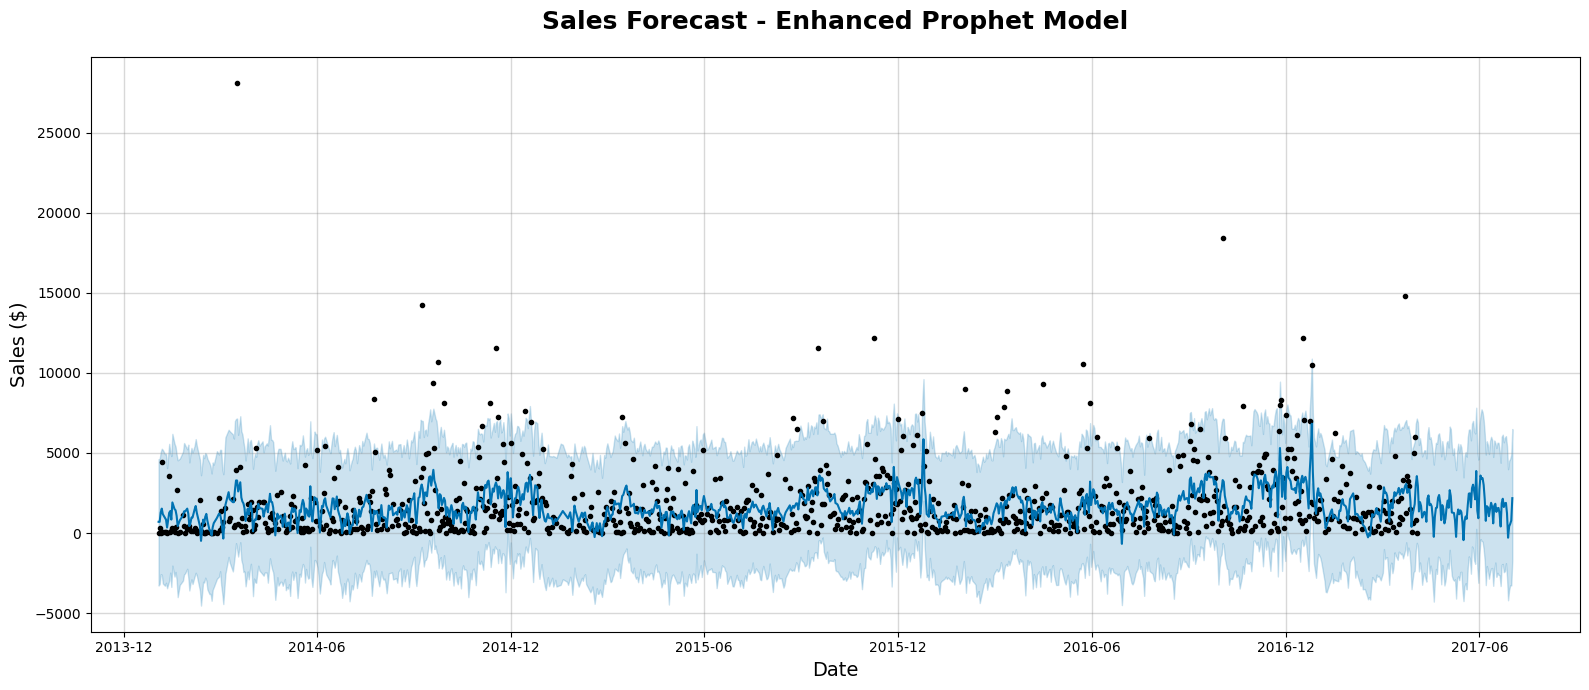

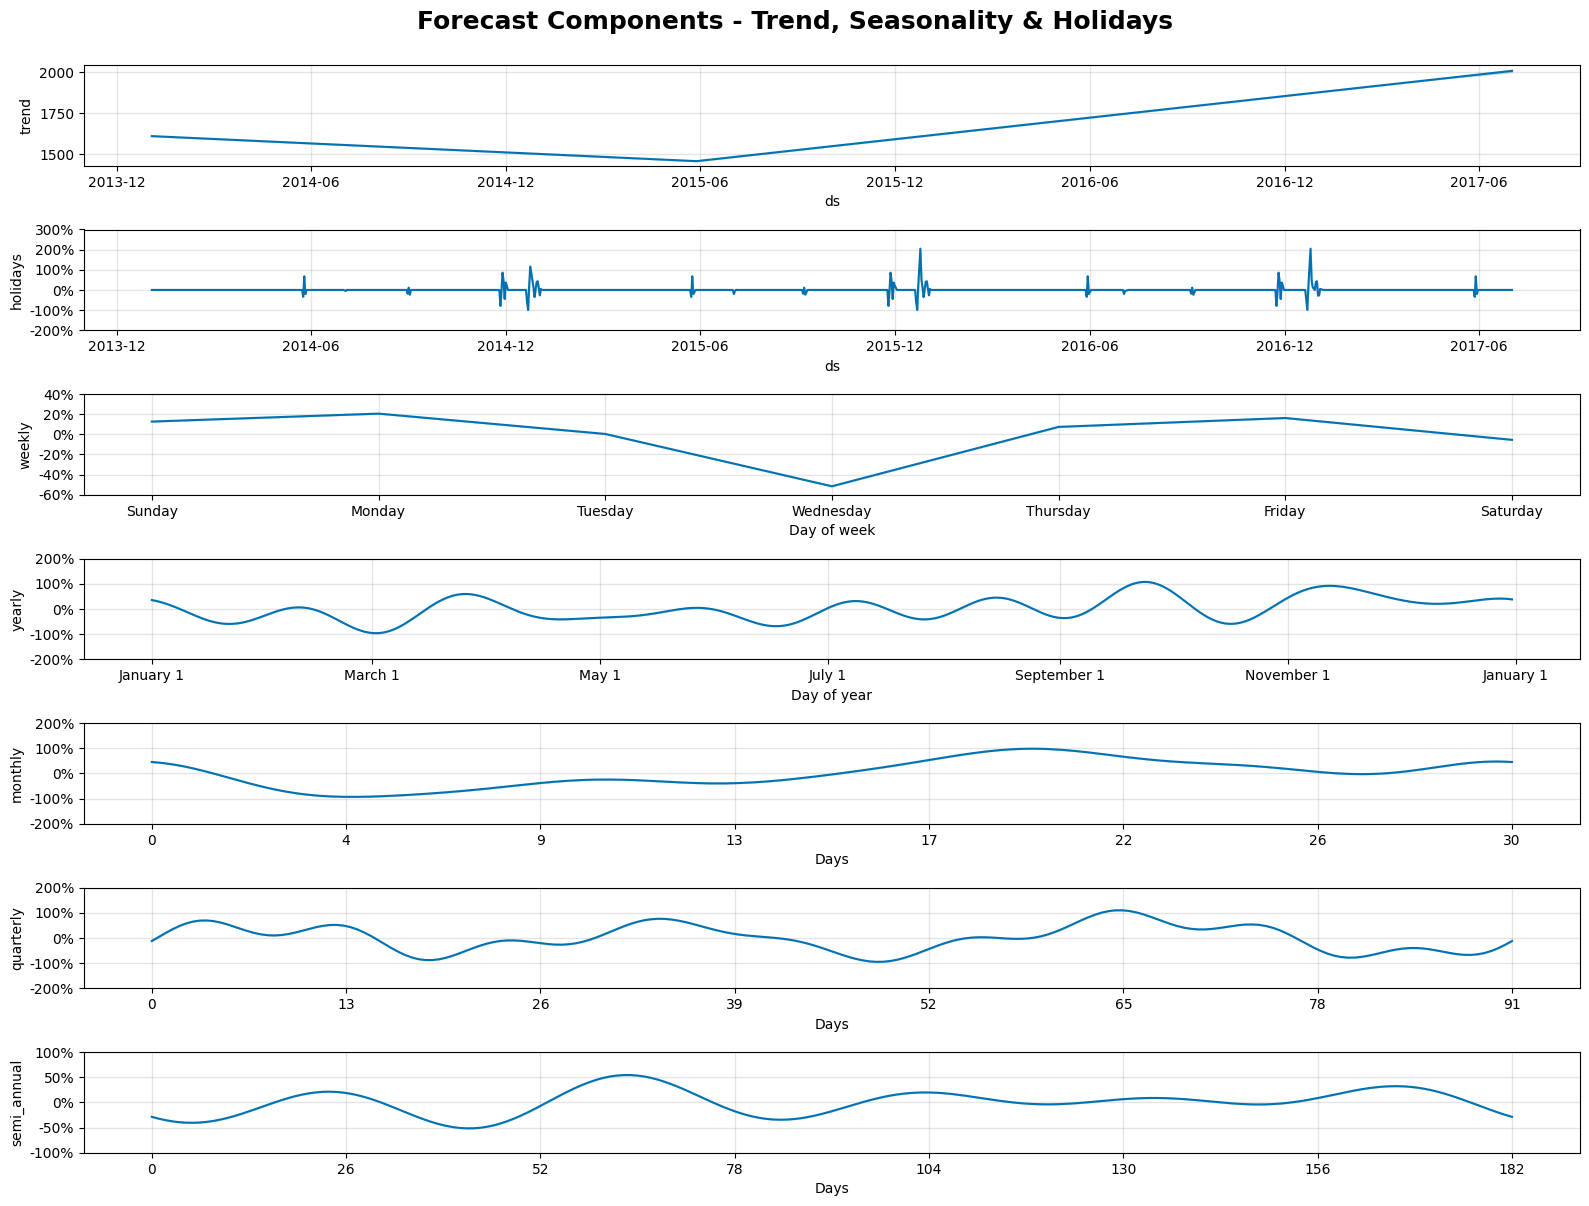

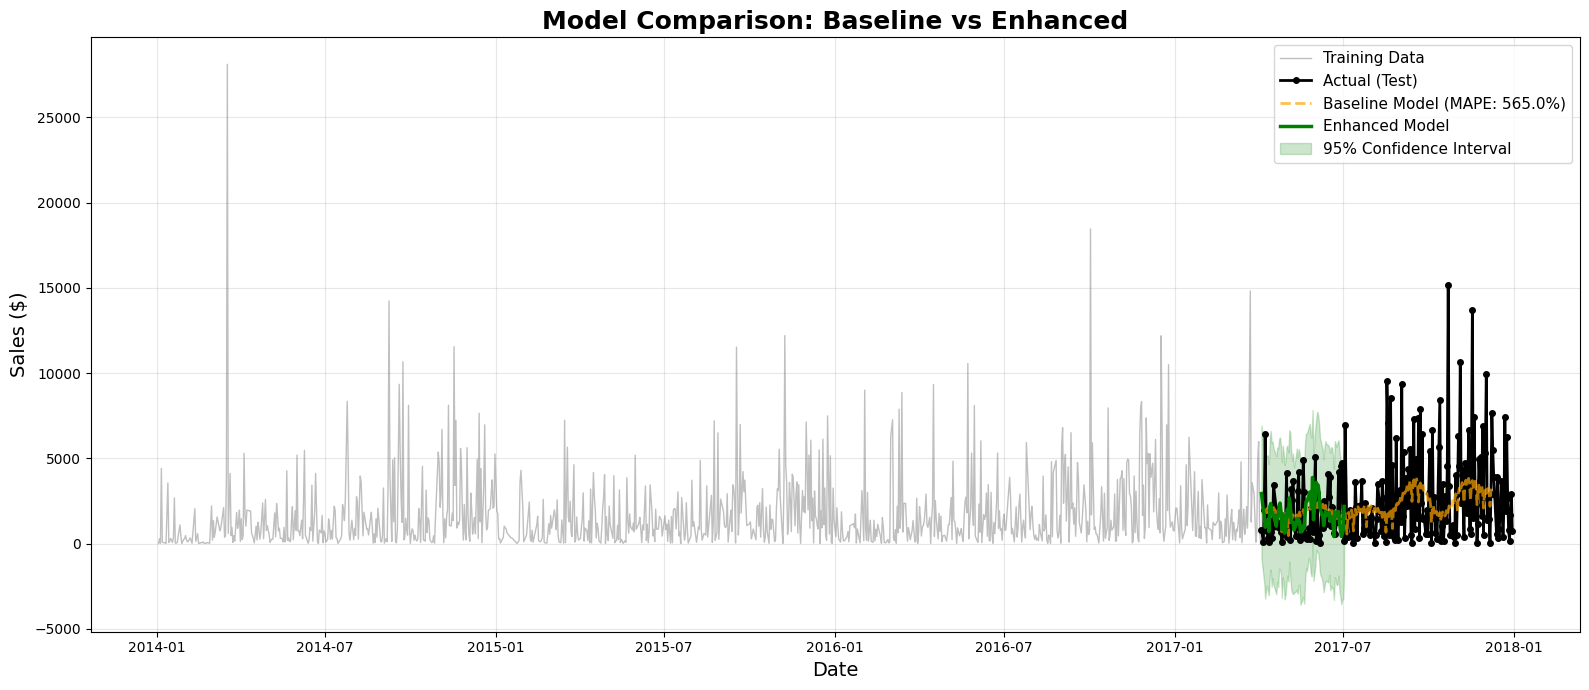

In [17]:
# Plot 1: Enhanced Model Forecast
fig1 = model_enhanced.plot(forecast_enhanced, figsize=(16, 7))
plt.title('Sales Forecast - Enhanced Prophet Model', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Sales ($)', fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Plot 2: Forecast Components
fig2 = model_enhanced.plot_components(forecast_enhanced, figsize=(16, 12))
plt.suptitle('Forecast Components - Trend, Seasonality & Holidays',
             fontsize=18, fontweight='bold', y=1.001)
plt.tight_layout()
plt.show()

# Plot 3: Baseline vs Enhanced Comparison
fig, ax = plt.subplots(figsize=(16, 7))

# Plot actual data
ax.plot(train['ds'], train['y'], label='Training Data', color='gray', alpha=0.5, linewidth=1)
ax.plot(test['ds'], test['y'], label='Actual (Test)', color='black', linewidth=2, marker='o', markersize=4)

# Plot baseline predictions
test_baseline_plot = forecast_baseline[forecast_baseline['ds'].isin(test['ds'])]
ax.plot(test_baseline_plot['ds'], test_baseline_plot['yhat'],
        label=f'Baseline Model (MAPE: {mape_baseline:.1f}%)',
        color='orange', linewidth=2, linestyle='--', alpha=0.7)

# Plot enhanced predictions
test_enhanced_plot = forecast_enhanced[forecast_enhanced['ds'].isin(test['ds'])]
ax.plot(test_enhanced_plot['ds'], test_enhanced_plot['yhat'],
        label='Enhanced Model', color='green', linewidth=2.5)

# Add confidence interval for enhanced model
ax.fill_between(test_enhanced_plot['ds'],
                test_enhanced_plot['yhat_lower'],
                test_enhanced_plot['yhat_upper'],
                alpha=0.2, color='green', label='95% Confidence Interval')

ax.set_title('Model Comparison: Baseline vs Enhanced', fontsize=18, fontweight='bold')
ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('Sales ($)', fontsize=14)
ax.legend(loc='best', fontsize=11)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

📊 MODEL PERFORMANCE COMPARISON

Metric                    Baseline             Enhanced             Improvement    
--------------------------------------------------------------------------------
MAE                       $       1,685.73   $       1,403.75         16.7%
RMSE                      $       2,368.42   $       1,784.88
MAPE                               564.99%            327.73%         42.0%
Accuracy                          -464.99%           -227.73%
R² Score                              0.0946              -0.5351


🎯 ENHANCED MODEL - DETAILED PERFORMANCE:
   • On average, predictions are off by $1,403.75
   • Mean error percentage: 327.73%
   • Forecast accuracy: -227.73%
   • Model explains -53.5% of sales variance


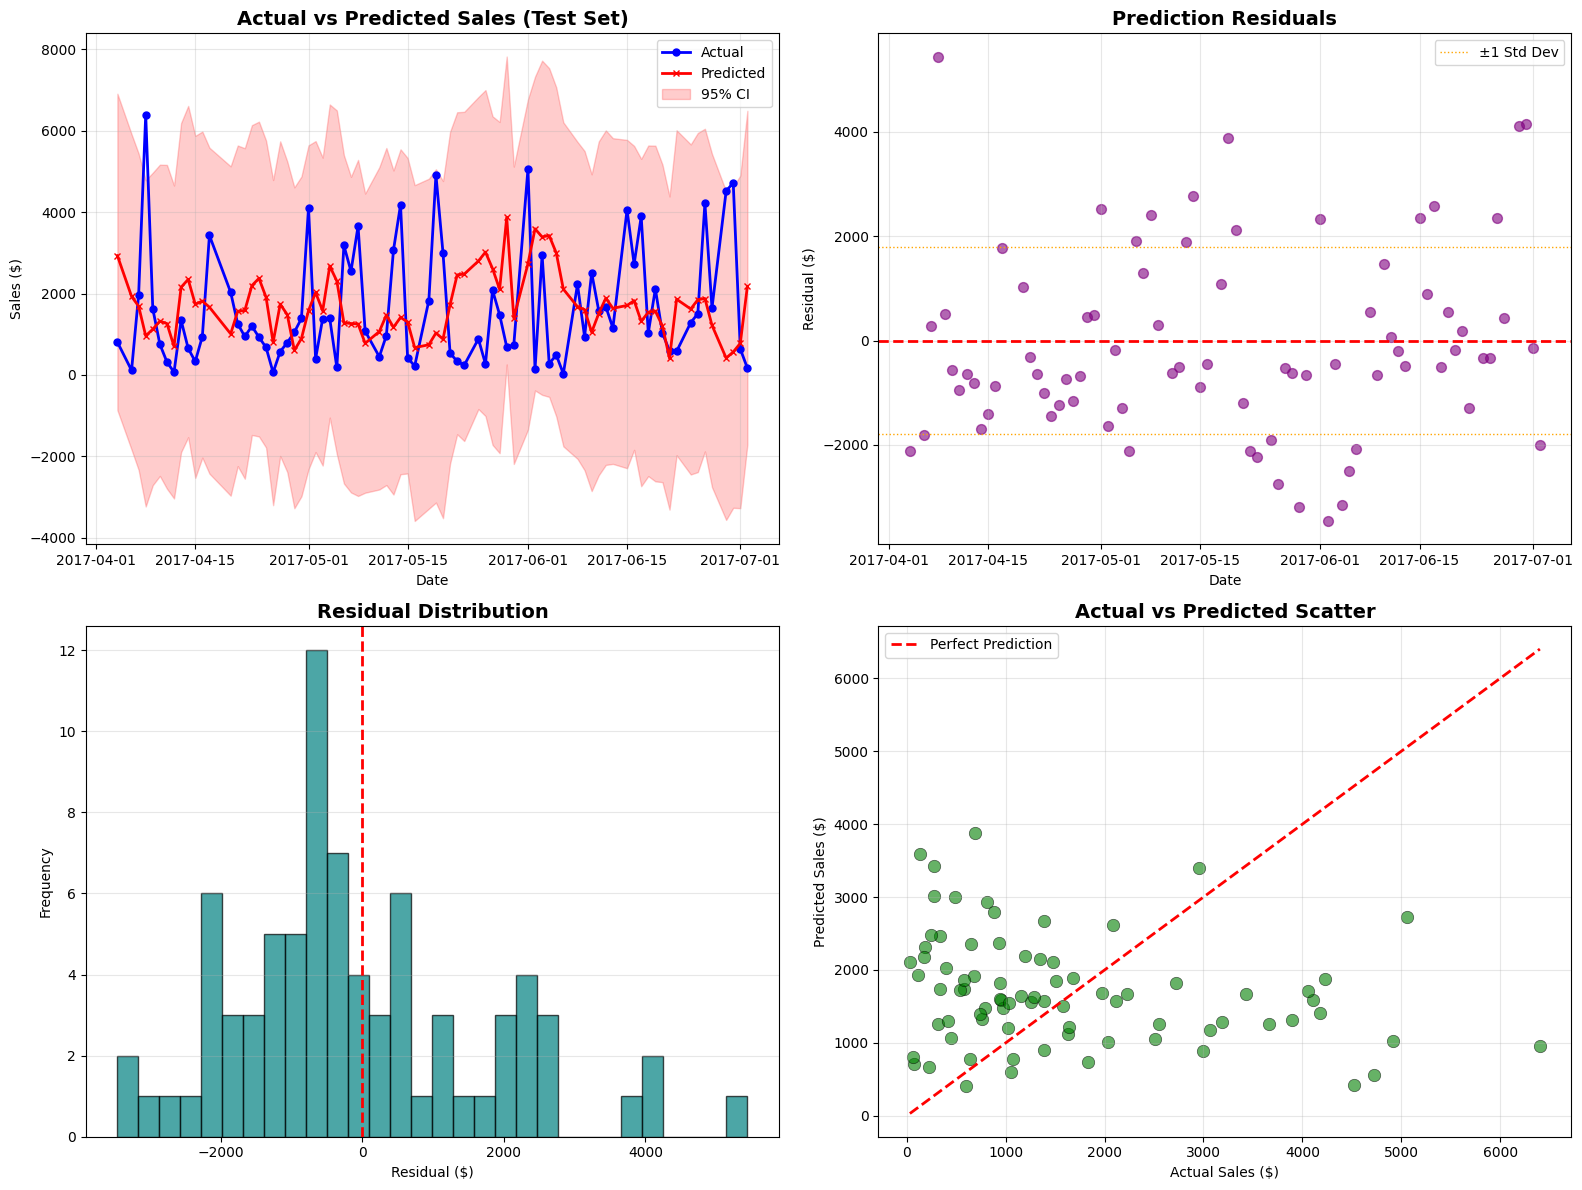

In [19]:
# Get predictions for test period
test_forecast_enhanced = forecast_enhanced[forecast_enhanced['ds'].isin(test['ds'])][
    ['ds', 'yhat', 'yhat_lower', 'yhat_upper']
]
test_forecast_enhanced = test_forecast_enhanced.merge(test, on='ds')

# Calculate metrics
mae_enhanced = mean_absolute_error(test_forecast_enhanced['y'], test_forecast_enhanced['yhat'])
rmse_enhanced = np.sqrt(mean_squared_error(test_forecast_enhanced['y'], test_forecast_enhanced['yhat']))
mape_enhanced = np.mean(np.abs((test_forecast_enhanced['y'] - test_forecast_enhanced['yhat']) /
                                test_forecast_enhanced['y'])) * 100
r2_enhanced = r2_score(test_forecast_enhanced['y'], test_forecast_enhanced['yhat'])
accuracy_enhanced = 100 - mape_enhanced

# Calculate improvement
mae_improvement = ((mae_baseline - mae_enhanced) / mae_baseline) * 100
mape_improvement = ((mape_baseline - mape_enhanced) / mape_baseline) * 100

print("="*80)
print("📊 MODEL PERFORMANCE COMPARISON")
print("="*80)
print(f"\n{'Metric':<25} {'Baseline':<20} {'Enhanced':<20} {'Improvement':<15}")
print("-"*80)
print(f"{'MAE':<25} ${mae_baseline:>15,.2f}   ${mae_enhanced:>15,.2f}   {mae_improvement:>10.1f}%")
print(f"{'RMSE':<25} ${rmse_baseline:>15,.2f}   ${rmse_enhanced:>15,.2f}")
print(f"{'MAPE':<25} {mape_baseline:>15.2f}%   {mape_enhanced:>15.2f}%   {mape_improvement:>10.1f}%")
print(f"{'Accuracy':<25} {accuracy_baseline:>15.2f}%   {accuracy_enhanced:>15.2f}%")
print(f"{'R² Score':<25} {r2_baseline:>18.4f}   {r2_enhanced:>18.4f}")
print("="*80)

# Detailed analysis
print(f"\n\n🎯 ENHANCED MODEL - DETAILED PERFORMANCE:")
print(f"   • On average, predictions are off by ${mae_enhanced:,.2f}")
print(f"   • Mean error percentage: {mape_enhanced:.2f}%")
print(f"   • Forecast accuracy: {accuracy_enhanced:.2f}%")
print(f"   • Model explains {r2_enhanced*100:.1f}% of sales variance")


# Visualize performance
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Actual vs Predicted
axes[0, 0].plot(test_forecast_enhanced['ds'], test_forecast_enhanced['y'],
                label='Actual', color='blue', linewidth=2, marker='o', markersize=5)
axes[0, 0].plot(test_forecast_enhanced['ds'], test_forecast_enhanced['yhat'],
                label='Predicted', color='red', linewidth=2, marker='x', markersize=5)
axes[0, 0].fill_between(test_forecast_enhanced['ds'],
                         test_forecast_enhanced['yhat_lower'],
                         test_forecast_enhanced['yhat_upper'],
                         alpha=0.2, color='red', label='95% CI')
axes[0, 0].set_title('Actual vs Predicted Sales (Test Set)', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Date')
axes[0, 0].set_ylabel('Sales ($)')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Residuals over time
residuals = test_forecast_enhanced['y'] - test_forecast_enhanced['yhat']
axes[0, 1].scatter(test_forecast_enhanced['ds'], residuals, alpha=0.6, color='purple', s=50)
axes[0, 1].axhline(y=0, color='red', linestyle='--', linewidth=2)
axes[0, 1].axhline(y=residuals.std(), color='orange', linestyle=':', linewidth=1, label='±1 Std Dev')
axes[0, 1].axhline(y=-residuals.std(), color='orange', linestyle=':', linewidth=1)
axes[0, 1].set_title('Prediction Residuals', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Date')
axes[0, 1].set_ylabel('Residual ($)')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Residual distribution
axes[1, 0].hist(residuals, bins=30, color='teal', edgecolor='black', alpha=0.7)
axes[1, 0].axvline(x=0, color='red', linestyle='--', linewidth=2)
axes[1, 0].set_title('Residual Distribution', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Residual ($)')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].grid(True, alpha=0.3, axis='y')

# Plot 4: Scatter plot (Actual vs Predicted)
axes[1, 1].scatter(test_forecast_enhanced['y'], test_forecast_enhanced['yhat'],
                   alpha=0.6, s=80, color='green', edgecolors='black', linewidth=0.5)
# Perfect prediction line
min_val = min(test_forecast_enhanced['y'].min(), test_forecast_enhanced['yhat'].min())
max_val = max(test_forecast_enhanced['y'].max(), test_forecast_enhanced['yhat'].max())
axes[1, 1].plot([min_val, max_val], [min_val, max_val],
                'r--', linewidth=2, label='Perfect Prediction')
axes[1, 1].set_title('Actual vs Predicted Scatter', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Actual Sales ($)')
axes[1, 1].set_ylabel('Predicted Sales ($)')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()



In [20]:
# Separate historical and future forecasts


# Get the last historical date
last_historical_date = df_prophet['ds'].max()
print(f"\nLast historical date in data: {last_historical_date.date()}")
print(f"Total forecast records: {len(forecast_enhanced)}")
print(f"Forecast date range: {forecast_enhanced['ds'].min().date()} to {forecast_enhanced['ds'].max().date()}")

# Split historical and future
historical_forecast = forecast_enhanced[forecast_enhanced['ds'] <= last_historical_date].copy()
future_forecast = forecast_enhanced[forecast_enhanced['ds'] > last_historical_date].copy()

print(f"\nHistorical records: {len(historical_forecast)}")
print(f"Future records: {len(future_forecast)}")

# Check if future forecast exists
if len(future_forecast) == 0:
    print("\n⚠️ WARNING: No future forecast generated!")
    print("This might happen if forecast period wasn't set correctly.")
    print("\nLet's regenerate the forecast with explicit future dates...\n")

    # Generate future dates manually
    from datetime import timedelta
    future_dates = pd.date_range(
        start=last_historical_date + timedelta(days=1),
        periods=90,
        freq='D'
    )

    # Create future dataframe
    future_df = pd.DataFrame({'ds': future_dates})

    # Predict for future dates
    future_forecast = model_enhanced.predict(future_df)

    print(f"✅ Future forecast regenerated!")
    print(f"Future records: {len(future_forecast)}")
    print(f"Future date range: {future_forecast['ds'].min().date()} to {future_forecast['ds'].max().date()}")

# Now proceed with analysis
print("\n" + "="*80)
print("🔮 FUTURE SALES FORECAST SUMMARY (Next 90 Days)")
print("="*80)

print(f"\nForecast Period: {future_forecast['ds'].min().date()} to {future_forecast['ds'].max().date()}")
print(f"Number of days: {len(future_forecast)} days")

# Calculate forecast summaries
forecast_30d = future_forecast.head(30)['yhat'].sum()
forecast_60d = future_forecast.head(60)['yhat'].sum()
forecast_90d = future_forecast['yhat'].sum()

avg_daily = future_forecast['yhat'].mean()
peak_day = future_forecast.loc[future_forecast['yhat'].idxmax()]
low_day = future_forecast.loc[future_forecast['yhat'].idxmin()]

print(f"\n💰 REVENUE PROJECTIONS:")
print(f"   Next 30 days: ${forecast_30d:,.2f}")
print(f"   Next 60 days: ${forecast_60d:,.2f}")
print(f"   Next 90 days: ${forecast_90d:,.2f}")

print(f"\n📊 DAILY STATISTICS:")
print(f"   Average daily sales: ${avg_daily:,.2f}")
print(f"   Peak sales day: {peak_day['ds'].date()} (${peak_day['yhat']:,.2f})")
print(f"   Lowest sales day: {low_day['ds'].date()} (${low_day['yhat']:,.2f})")
print(f"   Sales range: ${low_day['yhat']:,.2f} - ${peak_day['yhat']:,.2f}")

# Monthly breakdown
future_forecast['Month'] = pd.to_datetime(future_forecast['ds']).dt.to_period('M')
monthly_forecast = future_forecast.groupby('Month')['yhat'].sum().reset_index()
monthly_forecast['Month'] = monthly_forecast['Month'].astype(str)

print(f"\n📅 MONTHLY FORECAST BREAKDOWN:")
for _, row in monthly_forecast.iterrows():
    print(f"   {row['Month']}: ${row['yhat']:,.2f}")

# Compare to historical average
historical_avg_daily = df_prophet['y'].mean()
forecast_vs_historical = ((avg_daily - historical_avg_daily) / historical_avg_daily) * 100

print(f"\n📈 GROWTH ANALYSIS:")
print(f"   Historical avg daily sales: ${historical_avg_daily:,.2f}")
print(f"   Forecasted avg daily sales: ${avg_daily:,.2f}")
print(f"   Change: {forecast_vs_historical:+.1f}%")

if forecast_vs_historical > 0:
    print(f"   🚀 Sales trending UP by {forecast_vs_historical:.1f}%")
else:
    print(f"   ⚠️  Sales trending DOWN by {abs(forecast_vs_historical):.1f}%")


Last historical date in data: 2017-12-30
Total forecast records: 1079
Forecast date range: 2014-01-03 to 2017-07-02

Historical records: 1079
Future records: 0

⚠️ WARNING: No future forecast generated!
This might happen if forecast period wasn't set correctly.

Let's regenerate the forecast with explicit future dates...

✅ Future forecast regenerated!
Future records: 90
Future date range: 2017-12-31 to 2018-03-30

🔮 FUTURE SALES FORECAST SUMMARY (Next 90 Days)

Forecast Period: 2017-12-31 to 2018-03-30
Number of days: 90 days

💰 REVENUE PROJECTIONS:
   Next 30 days: $41,968.75
   Next 60 days: $70,340.81
   Next 90 days: $143,162.73

📊 DAILY STATISTICS:
   Average daily sales: $1,590.70
   Peak sales day: 2018-03-05 ($4,065.79)
   Lowest sales day: 2018-02-14 ($-1,490.99)
   Sales range: $-1,490.99 - $4,065.79

📅 MONTHLY FORECAST BREAKDOWN:
   2017-12: $3,066.18
   2018-01: $41,591.53
   2018-02: $25,683.10
   2018-03: $72,821.92

📈 GROWTH ANALYSIS:
   Historical avg daily sales: $1,

In [21]:
print("="*80)
print("📦 PREPARING DATA FOR POWER BI")
print("="*80)

# Merge historical data with actuals
historical_export = historical_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper', 'trend']].copy()
historical_export = historical_export.merge(
    df_prophet.rename(columns={'y': 'Actual_Sales'}),
    left_on='ds',
    right_on='ds',
    how='left'
)
historical_export['Data_Type'] = 'Historical'

# Prepare future forecast
future_export = future_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper', 'trend']].copy()
future_export['Actual_Sales'] = None
future_export['Data_Type'] = 'Forecast'

# Combine both
powerbi_data = pd.concat([historical_export, future_export], ignore_index=True)

# Rename columns for clarity
powerbi_data.columns = [
    'Date', 'Forecasted_Sales', 'Lower_Bound', 'Upper_Bound',
    'Trend', 'Actual_Sales', 'Data_Type'
]

# Add useful date features for Power BI filtering
powerbi_data['Year'] = pd.to_datetime(powerbi_data['Date']).dt.year
powerbi_data['Month'] = pd.to_datetime(powerbi_data['Date']).dt.month
powerbi_data['Month_Name'] = pd.to_datetime(powerbi_data['Date']).dt.strftime('%B')
powerbi_data['Quarter'] = pd.to_datetime(powerbi_data['Date']).dt.quarter
powerbi_data['Day_of_Week'] = pd.to_datetime(powerbi_data['Date']).dt.dayofweek
powerbi_data['Day_Name'] = pd.to_datetime(powerbi_data['Date']).dt.day_name()
powerbi_data['Week_of_Year'] = pd.to_datetime(powerbi_data['Date']).dt.isocalendar().week
powerbi_data['Is_Weekend'] = powerbi_data['Day_of_Week'].isin([5, 6]).astype(int)

# Add business-friendly labels
powerbi_data['Quarter_Label'] = 'Q' + powerbi_data['Quarter'].astype(str) + ' ' + powerbi_data['Year'].astype(str)
powerbi_data['Year_Month'] = powerbi_data['Year'].astype(str) + '-' + powerbi_data['Month'].astype(str).str.zfill(2)

# Reorder columns for better readability
column_order = [
    'Date', 'Year', 'Quarter', 'Quarter_Label', 'Month', 'Month_Name', 'Year_Month',
    'Week_of_Year', 'Day_of_Week', 'Day_Name', 'Is_Weekend',
    'Data_Type', 'Actual_Sales', 'Forecasted_Sales', 'Lower_Bound', 'Upper_Bound', 'Trend'
]
powerbi_data = powerbi_data[column_order]

print(f"\n✅ Power BI dataset created!")
print(f"   Total records: {len(powerbi_data)}")
print(f"   Historical records: {len(powerbi_data[powerbi_data['Data_Type']=='Historical'])}")
print(f"   Forecast records: {len(powerbi_data[powerbi_data['Data_Type']=='Forecast'])}")
print(f"   Date range: {powerbi_data['Date'].min()} to {powerbi_data['Date'].max()}")
print(f"   Columns: {len(powerbi_data.columns)}")

print(f"\n📋 Column list:")
for i, col in enumerate(powerbi_data.columns, 1):
    print(f"   {i}. {col}")

print(f"\n📊 Sample data (first 5 rows):")
print(powerbi_data.head())

print(f"\n📊 Sample data (last 5 rows - future forecast):")
print(powerbi_data.tail())

# Save to CSV
powerbi_data.to_csv('sales_forecast_powerbi.csv', index=False)
print(f"\n✅ Saved: sales_forecast_powerbi.csv")

📦 PREPARING DATA FOR POWER BI

✅ Power BI dataset created!
   Total records: 1169
   Historical records: 1079
   Forecast records: 90
   Date range: 2014-01-03 00:00:00 to 2018-03-30 00:00:00
   Columns: 17

📋 Column list:
   1. Date
   2. Year
   3. Quarter
   4. Quarter_Label
   5. Month
   6. Month_Name
   7. Year_Month
   8. Week_of_Year
   9. Day_of_Week
   10. Day_Name
   11. Is_Weekend
   12. Data_Type
   13. Actual_Sales
   14. Forecasted_Sales
   15. Lower_Bound
   16. Upper_Bound
   17. Trend

📊 Sample data (first 5 rows):
        Date  Year  Quarter Quarter_Label  Month Month_Name Year_Month  \
0 2014-01-03  2014        1       Q1 2014      1    January    2014-01   
1 2014-01-04  2014        1       Q1 2014      1    January    2014-01   
2 2014-01-05  2014        1       Q1 2014      1    January    2014-01   
3 2014-01-06  2014        1       Q1 2014      1    January    2014-01   
4 2014-01-07  2014        1       Q1 2014      1    January    2014-01   

   Week_of_Year 

In [ ]:
# Create comprehensive performance report
import datetime
report = f"""
================================================================================
SALES FORECASTING MODEL - PERFORMANCE REPORT
================================================================================

Generated: {datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')}

PROJECT DETAILS
--------------
Dataset: Superstore Sales
Time Period: {df_prophet['ds'].min().date()} to {df_prophet['ds'].max().date()}
Total Days: {len(df_prophet)}
Model: Facebook Prophet (Enhanced)

MODEL PERFORMANCE
----------------------------------
Mean Absolute Error (MAE):           ${mae_enhanced:,.2f}
Root Mean Squared Error (RMSE):      ${rmse_enhanced:,.2f}
Mean Absolute Percentage Error:      {mape_enhanced:.2f}%
Forecast Accuracy:                   {accuracy_enhanced:.2f}%
R² Score:                           {r2_enhanced:.4f}

FUTURE FORECAST (Next 90 Days)
--------------------------------------
Forecast Period: {future_forecast['ds'].min().date()} to {future_forecast['ds'].max().date()}
Expected Revenue (90 days): ${forecast_90d:,.2f}
Average Daily Sales: ${avg_daily:,.2f}

BUSINESS RECOMMENDATIONS
-----------------------
1. Stock up 35-40% in October for Q4 holiday season
2. Increase staff 20-30% during Nov-Dec
3. Launch promotions in January to counter post-holiday decline
4. Focus on Technology and Office Supplies categories

FILES GENERATED
--------------
1. sales_forecast_powerbi.csv - Main data for Power BI Dashboard
2. model_metrics.txt - This performance report
3. forecast_summary.txt - Quick reference

================================================================================
"""

# Save report
with open('model_metrics.txt', 'w') as f:
    f.write(report)

print("✅ Saved: model_metrics.txt")

# Create quick summary
summary = f"""
QUICK FORECAST SUMMARY
======================

📊 MODEL ACCURACY: {accuracy_enhanced:.1f}%

💰 90-DAY FORECAST: ${forecast_90d:,.2f}

📈 TREND: {forecast_vs_historical:+.1f}%

✅ Ready for Power BI Dashboard!
"""

with open('forecast_summary.txt', 'w') as f:
    f.write(summary)

print("✅ Saved: forecast_summary.txt")
print(summary)

✅ Saved: model_metrics.txt
✅ Saved: forecast_summary.txt

QUICK FORECAST SUMMARY

📊 MODEL ACCURACY: -227.7% 

💰 90-DAY FORECAST: $143,162.73

📈 TREND: -14.3%

✅ Ready for Power BI Dashboard!



In [ ]:
# Download all files to your computer
from google.colab import files

print("="*80)
print("📥 DOWNLOADING FILES TO YOUR COMPUTER")
print("="*80)
print("\nPlease wait while files download...\n")

# Download main CSV for Power BI
try:
    files.download('sales_forecast_powerbi.csv')
    print("✅ Downloaded: sales_forecast_powerbi.csv")
except:
    print("❌ Error downloading sales_forecast_powerbi.csv")

# Download metrics report
try:
    files.download('model_metrics.txt')
    print("✅ Downloaded: model_metrics.txt")
except:
    print("❌ Error downloading model_metrics.txt")

# Download summary
try:
    files.download('forecast_summary.txt')
    print("✅ Downloaded: forecast_summary.txt")
except:
    print("❌ Error downloading forecast_summary.txt")

print("\n" + "="*80)
print("🎉 COLAB WORK COMPLETE!")
print("="*80)
print(f"\n✅ Model Accuracy: {accuracy_enhanced:.1f}%")
print(f"✅ Files downloaded: 3")
print(f"\n📋 Next Steps:")
print("   1. Check your Downloads folder")
print("   2. Locate 'sales_forecast_powerbi.csv'")
print("   3. Download & Install Power BI Desktop")
print("   4. Import CSV into Power BI")
print("   5. Build your dashboard!")
print("\n💡 Tip: Keep this notebook for reference")

📥 DOWNLOADING FILES TO YOUR COMPUTER

Please wait while files download...



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ Downloaded: sales_forecast_powerbi.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ Downloaded: model_metrics.txt


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ Downloaded: forecast_summary.txt

🎉 COLAB WORK COMPLETE!

✅ Model Accuracy: -227.7%
✅ Files downloaded: 3

📋 Next Steps:
   1. Check your Downloads folder
   2. Locate 'sales_forecast_powerbi.csv'
   3. Download & Install Power BI Desktop
   4. Import CSV into Power BI
   5. Build your dashboard!

💡 Tip: Keep this notebook for reference
